# Final Project of Computer Vision and Image Processing Lecture



---



Name                : Rayhan Adi Wicaksono <br/>
Student Number (NIM): 21/477186/TK/52550<br/>
Email: rayhan.adi.wicaksono@mail.ugm.ac.id<br/>

The objective of this project is to propose a methodology for the automatic classification of skin lesions, based on image analysis and machine learning.


Note: This Python Notebook is developed and tested in Google Colaboratory Environment.

# 0. Preparation

## 0.1. Import Packages

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import image
import cv2
from skimage.measure import regionprops, label
from skimage.measure import perimeter
from skimage.measure import label
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from imblearn.over_sampling import RandomOverSampler,SMOTE,KMeansSMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

## 0.2. Download Data from Cloud Storage

In [2]:
# Download and unzip data from google drive

data_path = "/content/Project"

if os.path.exists(data_path) == False:
  !gdown -q https://drive.google.com/uc?id=<<GOOGLE_DRIVE_PATH_ID>>
  !unzip -q data.zip

# 1. Data Loading

## 1.1. Separate the Directory of Image Based on Its Type

Code here will separate all available images into three different directories based on it's type: normal images, segmentation images, and superpixels images. This separation will make the next step easier.

In [3]:
# Define paths
image_data_path = '/content/Project/PROJECT_Data/'
normal_dest_path = '/content/data/normal/'
segmentation_dest_path = '/content/data/segmentation/'
superpixels_dest_path = '/content/data/superpixels/'

# Ensure destination directories exist
os.makedirs(normal_dest_path, exist_ok=True)
os.makedirs(segmentation_dest_path, exist_ok=True)
os.makedirs(superpixels_dest_path, exist_ok=True)

# Iterate over files in the source directory
for filename in os.listdir(image_data_path):
    source_path = os.path.join(image_data_path, filename)

    if filename.endswith(".jpg"):
        destination_path = os.path.join(normal_dest_path, filename)
    elif filename.endswith("_segmentation.png"):
        destination_path = os.path.join(segmentation_dest_path, filename)
    elif filename.endswith("_superpixels.png"):
        destination_path = os.path.join(superpixels_dest_path, filename)
    else:
        continue  # Skip files that do not match any of the criteria

    # Move the file
    os.rename(source_path, destination_path)

## 1.2. Load Ground Truth

Next, we will load the ground truth dataset which contain image_id and the classification if one image is classified as melanoma or not

In [4]:
df = pd.read_csv('/content/Project/ISIC_2017_Data_GroundTruth_Classification.csv')
df = df.drop(['seborrheic_keratosis'], axis = 1)

In [5]:
df.head()

,image_id,melanoma
0,ISIC_0000000,0.0
1,ISIC_0000001,0.0
2,ISIC_0000002,1.0
3,ISIC_0000003,0.0
4,ISIC_0000004,1.0


Let's try have a visual into the class distribution

In [6]:
df.melanoma.value_counts()

melanoma
0.0    1626
1.0     374
Name: count, dtype: int64

It's shown that our dataset is imbalanced, where only 374 row of total 2000 row of data that labeled as melanoma. We will use this information as consideration for the next step

## 1.3. Load Images

The next step is loading all three categories of images into list using cv2 packages. Normal images will be loaded as color images and both segmentation and superpixels images will be loaded as binary images.

In [7]:
# Define function for loading color images

def load_a_list_of_image(image_path):

  images = []

  filenames = sorted(os.listdir(image_path))

  for filename in filenames:
    img_data = cv2.imread(image_path + filename, cv2.IMREAD_COLOR)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    images.append(img_data)

  return images


In [8]:
def load_binary_image(image_path):

  images = list()

  filenames = sorted(os.listdir(image_path))

  for filename in filenames:
    img_data = cv2.imread(image_path + filename, cv2.IMREAD_GRAYSCALE)

    # Ensure the image is binary
    _, binary_image = cv2.threshold(img_data, 127, 255, cv2.THRESH_BINARY)

    images.append(img_data)

  return images


In [9]:
normal_images = load_a_list_of_image(normal_dest_path)
segmentation_images = load_binary_image(segmentation_dest_path)
superpixels_images = load_binary_image(superpixels_dest_path)

Wait a second, let's see the amount of the images

In [10]:
print(len(normal_images))

200


The amount of the images is only 200 images, which means we don't need all the row in the ground truth. Let's only take necessary row from ground truth.

In [11]:
# Get a list of all files in the directory
all_images_name = sorted(os.listdir(normal_dest_path))

all_images_name = pd.DataFrame(all_images_name, columns= ['image_id'])
all_images_name['image_id'] = all_images_name['image_id'].str.replace('.jpg', '')

df = pd.merge(all_images_name, df, on='image_id', how='inner')

In [12]:
df.shape

(200, 2)

## 1.4. Display Random 25 Images from Each List

### Display of Normal Images

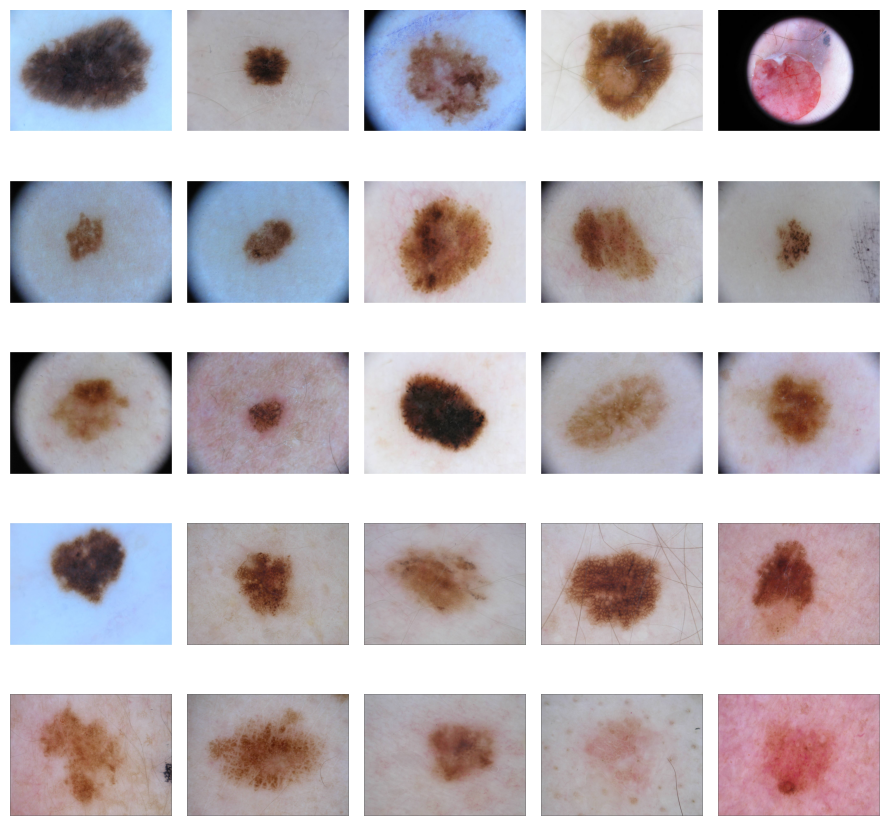

In [13]:
# Function to display the first 25 images from a list of loaded images
def display_first_images(images, num_images=25, grid_size=(5, 5)):
    # Ensure the number of images to display does not exceed the number of available images
    num_images = min(num_images, len(images))

    # Select the first num_images images
    selected_images = images[:num_images]

    # Create a figure to display the images
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(9, 9))
    axes = axes.flatten()

    for img, ax in zip(selected_images, axes):
        # Display the image
        ax.imshow(img)
        ax.axis('off')

    # Hide any remaining axes if the number of images is less than grid size
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

display_first_images(normal_images)

### Display of Segmentation Images

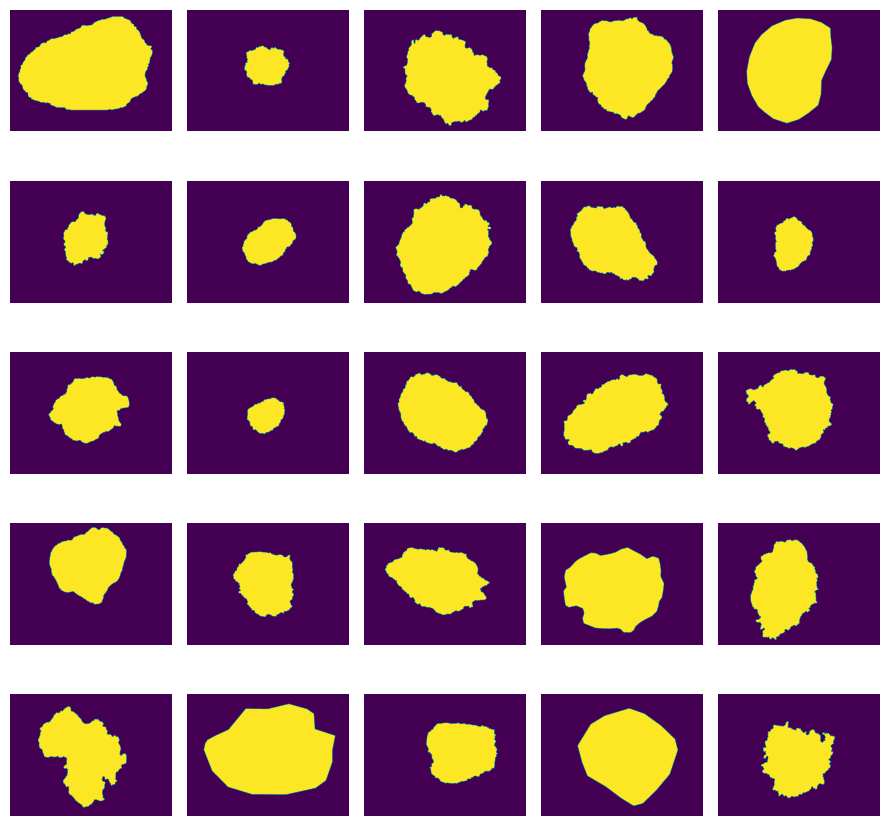

In [14]:
display_first_images(segmentation_images)

### Display of Superpixels Images

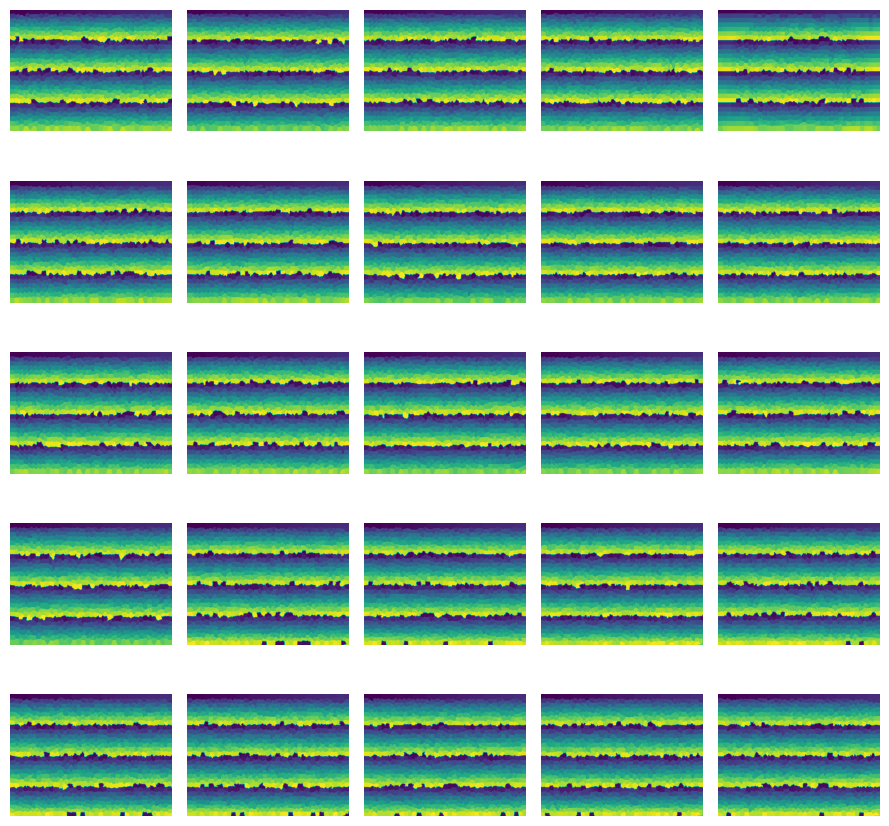

In [15]:
display_first_images(superpixels_images)

# 2. Feature Extraction

In this project, ABCDE method [1] will be used as theory basis for the image processing method that will be used. ABCDE stands for Asymmetry, Border, Color, Diameter, and Evolving. Here is the explanation of each ABCDE of Melanoma.



*   Asymmetry: One half of the spot is not as the same as the other half.
*   Border: Have irregular shape of border, where non-cancerous moles usually have smooth border.
*   Color: Have more than one color or shade
*   Diameter: Larger than 6mm
*   Evolution: Often change characteristics like change of size, shape, or color.

However, because the dataset does not contain the change of the lesion, the "Evolution" will be skiped


## 2.1. Asymmetry: Asymmetry of Object

To detect asymmetry of the object, this project simply split the image into halves, flip one side, and compare the simmiliarity between original half and the flipped one. The error will be used as feature to detect melanoma.

In [16]:
def calculate_asymmetry(mask):
    rows, cols = mask.shape
    center_row, center_col = rows // 2, cols // 2

    # Split the image into halves
    left_half = mask[:, :center_col]
    right_half = mask[:, center_col:]

    # Flip one half for comparison
    flipped_right_half = np.fliplr(right_half)

    # Ensure the halves are of the same size
    min_cols = min(left_half.shape[1], flipped_right_half.shape[1])
    left_half = left_half[:, :min_cols]
    flipped_right_half = flipped_right_half[:, :min_cols]

    # Calculate asymmetry
    asymmetry = np.sum(np.abs(left_half - flipped_right_half)) / np.sum(mask)
    return asymmetry

def calculate_list_asymmetry(masks):
    asymmetries = []

    for mask in masks:
        asymmetry = calculate_asymmetry(mask)
        asymmetries.append(asymmetry)

    return asymmetries

In [17]:
df['asymmetry'] = calculate_list_asymmetry(segmentation_images)

## 2.2. Border: Compactness of Object

To detect the border irregularity of the lesion object, Compactness will be used. Compactness is defined as

$$
K = \frac{4\pi A}{P}
$$

where A is the object area and the P is the object perimeter.

<br/>


To count the area and the perimeter, cv2 packages are used where cv2.arcLength function is used to count the perimeter and the cv2.contourArea used to count the area of the object.

In [18]:
def calculate_compactness(binary_image):

    # Resize image so that all image have the same scale
    new_width, new_height = 400, 400
    binary_image = cv2.resize(binary_image, (new_width, new_height))

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if there are any contours found
    if not contours:
        return 0

    # Find the largest contour
    contour = max(contours, key=cv2.contourArea)

    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    compactness = (4 * np.pi * area) / (perimeter ** 2)

    return [area, perimeter, compactness]


def calculate_list_calculate_compactness(masks):
    areas = []
    perimeters = []
    compactnesses = []

    for mask in masks:
        border_irregularity = calculate_compactness(mask)
        areas.append(border_irregularity[0])
        perimeters.append(border_irregularity[1])
        compactnesses.append(border_irregularity[2])

    border_irregularities_df = pd.DataFrame({
        'areas': areas,
        'perimeters': perimeters,
        'compactness': compactnesses
    })

    return border_irregularities_df

In [19]:
border_irregularities_df = calculate_list_calculate_compactness(segmentation_images)
df = pd.concat([df, border_irregularities_df], axis=1)
df = df.dropna()

## 2.3. Color: Pixel Intensity Variance

To identify the color or shade difference of the object, pixel intensity variance will be calculated. This feature try to get the variance of each color channel (Red, Green, Blue) and grayscale channel so that the difference of the color in the object can be quantified.

In [20]:
def calculate_color_irregularity(image, mask):

    # RGB Channel Pixel Intensity Variance
    masked_image = image * np.stack([mask, mask, mask], axis=-1)
    color_channels = cv2.split(masked_image)
    color_variances = [np.var(channel[mask > 0]) for channel in color_channels]

    # Grayscale Channel Pixel Intensity Variance
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    grayscale_masked_image = grayscale_image * mask
    gray_variance = np.var(grayscale_masked_image[mask > 0])

    # Concat Variance
    variances = color_variances + [gray_variance]

    return variances

def calculate_list_color_irregularity(images, masks):
    irregularities_r = []
    irregularities_g = []
    irregularities_b = []
    irregularities_gray = []

    for image, mask in zip(images, masks):
        irreqularities = calculate_color_irregularity(image, mask)
        irregularities_r.append(irreqularities[0])
        irregularities_g.append(irreqularities[1])
        irregularities_b.append(irreqularities[2])
        irregularities_gray.append(irreqularities[3])

    irregularities_df = pd.DataFrame({
        'R': irregularities_r,
        'G': irregularities_g,
        'B': irregularities_b,
        'Gray': irregularities_gray
    })

    return irregularities_df

In [21]:
irregularities_df = calculate_list_color_irregularity(normal_images, segmentation_images)
df = pd.concat([df, irregularities_df], axis=1)
df = df.dropna()

In [22]:
df.head()

,image_id,melanoma,asymmetry,areas,perimeters,compactness,R,G,B,Gray
0,ISIC_0000000,0.0,0.072908,74298.5,1145.075242,0.712069,1302.025000,1540.511213,1829.708204,1483.939080
1,ISIC_0000001,0.0,0.100185,10837.0,479.303603,0.592785,1020.267742,647.736774,418.232452,704.381680
2,ISIC_0000002,1.0,0.044751,48264.0,1108.631590,0.493468,301.100385,815.281211,1419.613100,672.263820
3,ISIC_0000003,0.0,0.012707,53059.0,1015.175747,0.646973,1219.795559,1208.875778,969.838020,1152.345713
4,ISIC_0000004,1.0,0.274866,54822.0,942.465073,0.775594,911.482637,1165.910012,1458.002001,881.270657


## 2.4. Diameter: Outer Diameter Calculation

As for diameter, Outer diameter is used. Outer diameter is the diameter of largest circle that can fit completely into the lesion object.



In [23]:
def calculate_diameter(binary_image):

    new_width, new_height = 400, 400
    binary_image = cv2.resize(binary_image, (new_width, new_height))

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if there are any contours found
    if not contours:
        return 0

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Compute the minimum enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)

    # Compute the diameter
    diameter = 2 * radius

    return diameter

def calculate_list_diameter(masks):
    diameters = []

    for mask in masks:
        diameter = calculate_diameter(mask)
        diameters.append(diameter)

    return diameters

In [24]:
diameters = calculate_list_diameter(segmentation_images)
df['Diameters'] = diameters

In [25]:
df.head()

,image_id,melanoma,asymmetry,areas,perimeters,compactness,R,G,B,Gray,Diameters
0,ISIC_0000000,0.0,0.072908,74298.5,1145.075242,0.712069,1302.025000,1540.511213,1829.708204,1483.939080,355.951324
1,ISIC_0000001,0.0,0.100185,10837.0,479.303603,0.592785,1020.267742,647.736774,418.232452,704.381680,134.609940
2,ISIC_0000002,1.0,0.044751,48264.0,1108.631590,0.493468,301.100385,815.281211,1419.613100,672.263820,313.193451
3,ISIC_0000003,0.0,0.012707,53059.0,1015.175747,0.646973,1219.795559,1208.875778,969.838020,1152.345713,336.411133
4,ISIC_0000004,1.0,0.274866,54822.0,942.465073,0.775594,911.482637,1165.910012,1458.002001,881.270657,347.094696


# 3. Classification

## 3.1. Exploratory Data Analysis

### 3.1.1. Tabular Dataset for Machine Learning Model Training

Here is the final dataset that contain extracted feature and the target variable.

In [26]:
df.head()

,image_id,melanoma,asymmetry,areas,perimeters,compactness,R,G,B,Gray,Diameters
0,ISIC_0000000,0.0,0.072908,74298.5,1145.075242,0.712069,1302.025000,1540.511213,1829.708204,1483.939080,355.951324
1,ISIC_0000001,0.0,0.100185,10837.0,479.303603,0.592785,1020.267742,647.736774,418.232452,704.381680,134.609940
2,ISIC_0000002,1.0,0.044751,48264.0,1108.631590,0.493468,301.100385,815.281211,1419.613100,672.263820,313.193451
3,ISIC_0000003,0.0,0.012707,53059.0,1015.175747,0.646973,1219.795559,1208.875778,969.838020,1152.345713,336.411133
4,ISIC_0000004,1.0,0.274866,54822.0,942.465073,0.775594,911.482637,1165.910012,1458.002001,881.270657,347.094696


### 3.2.2. Pearson Correlation between Features

To get information about the quality of feature that has been created, I used Pearson Correlation, which show how the correlation between each features and target variable.

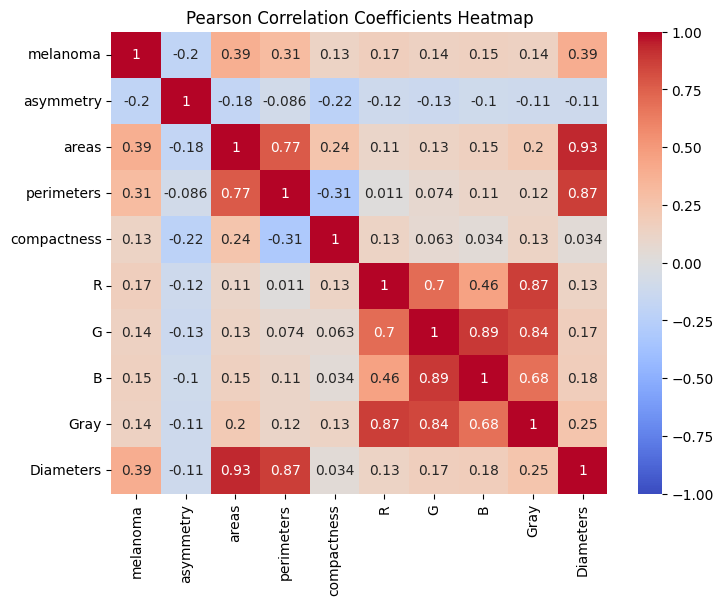

In [27]:
# Step 2: Calculate Pearson correlation coefficients
correlation_matrix = df.drop(['image_id'], axis = 1).corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Coefficients Heatmap')
plt.show()

The heatmap shows that diameters, areas, and perimeters have nearly 0.4 correlation to melanoma, but those feature is highly correlated. I consider to drop the areas feature.

As for the another feature will be used for training the model

In [28]:
df = df.drop(['areas'], axis = 1)

### 3.1.3. KDE Plot

Here is the KDE plot that show the distribution of each feature.

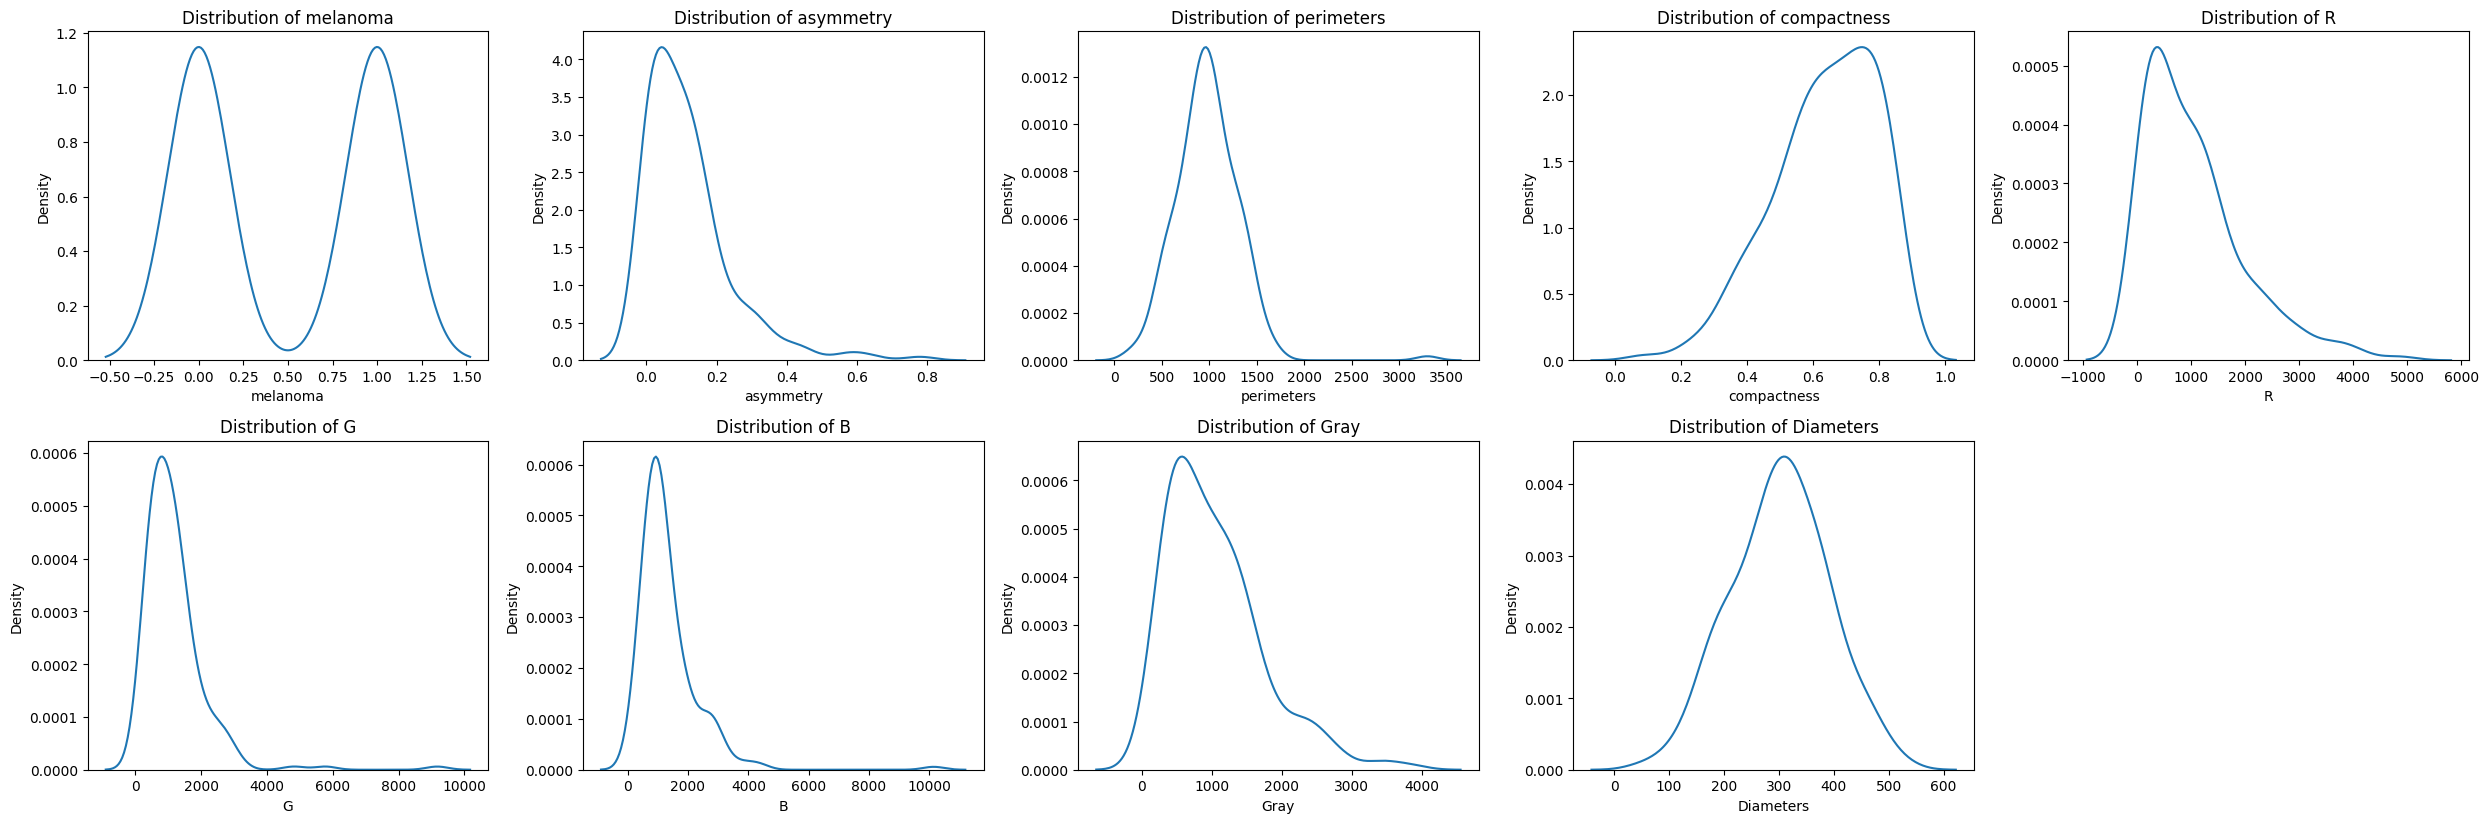

In [29]:
def create_kde_plot(df):
  df_numerical = df.select_dtypes(include=[np.number, bool])
  numerical_columns = df_numerical.columns

  # Define the number of rows and columns you want for your subplots
  num_columns = len(df_numerical.columns)
  num_rows = int(np.ceil(num_columns / 4))  # Adjust the denominator to change the number of columns per row

  # Create a figure object and define the size
  plt.figure(figsize=(25, 4 * num_rows))  # Adjust the size as needed

  # Loop through the numerical columns and create a subplot for each
  for i, column in enumerate(df_numerical.columns):
      plt.subplot(num_rows, 5, i + 1)  # Adjust the number '3' based on the number of columns per row
      sns.kdeplot(data=df_numerical[column])
      plt.title(f"Distribution of {column}")

  # Adjust layout for better spacing between plots
  plt.tight_layout()
  plt.show()

create_kde_plot(df)

All those features looks normally distributed but have a lot of outlier.

## 3.2. Data Preprocessing

### 3.2.1. Outlier Handling

To handle the outlier, clipping method is used, where the outlier will be set as higher or lower quantile with threshold = 0.01 (1%)

In [30]:
def clip_outlier(df, column, threshold):
  min_threshold = threshold
  max_threshold = 1 - threshold

  df.loc[:, column] = df[column].clip(df[column].quantile(min_threshold), df[column].quantile(max_threshold))

  return df

features = ['R', 'G', 'B', 'Gray', 'asymmetry', 'perimeters', 'compactness', 'Diameters']

for feature in features:
  df = clip_outlier(df, feature, 0.01)

###3.2.2. Feature Scaling

As for the features does not have the same scale of value, we will use Robust Scaler to improve the quality of the data

In [31]:
from sklearn.preprocessing import StandardScaler

features = ['R', 'G', 'B', 'Gray', 'asymmetry', 'perimeters', 'compactness', 'Diameters']

scaler = RobustScaler()
scaled_features = scaler.fit_transform(df[features])
df[features] = scaled_features

## 3.3. Train Test Split

As for the dataset has been preprocessed, we will split the dataset with train:test = 80:20

In [32]:
X = df.drop(["image_id","melanoma"], axis=1)
y = df["melanoma"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 3.4. Modeling

In this project, four machine learning model will be used

### 3.4.1. Logistic Regression

In [33]:
def train_logistic_regression(X_train, y_train, X_test):

  # Train logistic regression model
  logreg = LogisticRegression(max_iter=10000)

  # Fit the model on the training data
  logreg.fit(X_train, y_train)

  # Predict Test Data
  y_pred_logreg = logreg.predict(X_test)

  return y_pred_logreg

### 3.4.2. Naive Bayes Classifier

In [34]:
def train_naive_bayes(X_train, y_train, X_test):

  # Train XGBoost model
  gnb = GaussianNB()

  # Fit the model on the training data
  gnb.fit(X_train, y_train)

  # Predict Test Data
  y_pred_gnb = gnb.predict(X_test)

  return y_pred_gnb

### 3.4.3. Random Forest Classifier

In [35]:
def train_random_forest(X_train, y_train, X_test):

  # Train XGBoost model
  rf = RandomForestClassifier()

  # Fit the model on the training data
  rf.fit(X_train, y_train)

  # Predict Test Data
  y_pred_rf = rf.predict(X_test)

  return y_pred_rf

### 3.4.4. XGBoost Classifier

In [36]:
def train_xgboost(X_train, y_train, X_test):

  # Train XGBoost model
  xgb = XGBClassifier(enable_categorical = True)

  # Fit the model on the training data
  xgb.fit(X_train, y_train)

  # Predict Test Data
  y_pred_xgb = xgb.predict(X_test)

  return y_pred_xgb

## 3.5. Model Performance Evaluation

Let's check the performance of each machine learning models

In [37]:
def evaluate_models(X_train, y_train, X_val, y_val):
  # Define models
  models = {
      'Logistic Regression': train_logistic_regression(X_train, y_train, X_val),
      'Gaussian Naive Bayes': train_naive_bayes(X_train, y_train, X_val),
      'Random Forest Classifier': train_random_forest(X_train, y_train, X_val),
      'Extreme Gradient Boosting': train_xgboost(X_train, y_train, X_val)
  }

  # Initialize results dictionary
  results = {'Model': [], 'CM':[], 'Accuracy': [], 'F1 Score': []}

  predictions = pd.DataFrame()

  # Loop through models
  for name, function in models.items():

      # Predict on test set
      y_pred = function

      # Calculate evaluation metrics

      cm = confusion_matrix(y_val, y_pred)
      accuracy = accuracy_score(y_val, y_pred)
      f1 = f1_score(y_val, y_pred)

      # Append results to dictionary
      results['Model'].append(name)
      results['CM'].append(cm)
      results['Accuracy'].append(accuracy)
      results['F1 Score'].append(f1)

      predictions[f'{name} pred'] = y_pred

  # Convert results dictionary to DataFrame for easier viewing
  results_df = pd.DataFrame(results)

  actual_CT = y_val.reset_index(drop=True)
  predictions['actual_CT'] = actual_CT

  return results_df, predictions

val_results_df, val_predictions = evaluate_models(X_train, y_train, X_test, y_test)

val_results_df

,Model,CM,Accuracy,F1 Score
0,Logistic Regression,"[[18, 3], [5, 14]]",0.800,0.777778
1,Gaussian Naive Bayes,"[[19, 2], [4, 15]]",0.850,0.833333
2,Random Forest Classifier,"[[16, 5], [5, 14]]",0.750,0.736842
3,Extreme Gradient Boosting,"[[16, 5], [6, 13]]",0.725,0.702703


The table showed that Bayesian approach model that is Gaussian Naive Bayes model outperformed another model with 0.85 accuracy and 0.83 F1 Score. However, to make sure the quality of the model, Stratified 5-fold cross validation will be executed

## 3.6. Stratified 10-Fold Cross Validation

To make sure the result of our model is not overfit, Stratified 5-fold cross validation will be used.

In [38]:
def stratified_kfold_crossval(X_train_set, y_train_set, n_splits = 5):
  # Define the KFold cross-validator
  kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Initialize results dictionary
  cv_results = pd.DataFrame()

  i = 1

  for train_index, val_index in kf.split(X_train_set, y_train_set):

      # Train-test split using .iloc
      X_train = X_train_set.iloc[train_index]
      y_train = y_train_set.iloc[train_index]

      X_val = X_train_set.iloc[val_index]
      y_val = y_train_set.iloc[val_index]

      models = {
      'Logistic Regression': train_logistic_regression(X_train, y_train, X_val),
      'Gaussian Naive Bayes': train_naive_bayes(X_train, y_train, X_val),
      'Random Forest Classifier': train_random_forest(X_train, y_train, X_val),
      'Extreme Gradient Boosting': train_xgboost(X_train, y_train, X_val)
      }

      # Initialize results dictionary
      results = {'Model': [], 'CM':[], 'Accuracy': [], 'F1 Score': []}

      predictions = pd.DataFrame()

      # Loop through models
      for name, function in models.items():

          # Predict on test set
          y_pred = function

          # Calculate evaluation metrics

          cm = confusion_matrix(y_val, y_pred)
          accuracy = accuracy_score(y_val, y_pred)
          f1 = f1_score(y_val, y_pred)

          # Append results to dictionary
          results['Model'].append(name)
          results['CM'].append(cm)
          results['Accuracy'].append(accuracy)
          results['F1 Score'].append(f1)

          predictions[f'{name} pred'] = y_pred

      # Convert results dictionary to DataFrame for easier viewing
      results_df = pd.DataFrame(results)

      actual_CT = y_val.reset_index(drop=True)
      predictions['actual_CT'] = actual_CT

      results_df['Fold'] = i

      cv_results = pd.concat([cv_results, results_df], ignore_index=True)

      i += 1

  cv_results = cv_results.drop(['CM', 'Fold'], axis = 1)

  cv_results = cv_results.groupby(['Model']).mean()

  cv_results = cv_results.reset_index()

  return cv_results

cv_results = stratified_kfold_crossval(X, y)

In [39]:
cv_results.head(10)

,Model,Accuracy,F1 Score
0,Extreme Gradient Boosting,0.675,0.675715
1,Gaussian Naive Bayes,0.695,0.668890
2,Logistic Regression,0.670,0.661648
3,Random Forest Classifier,0.660,0.648862


After using stratified 5-fold cross validation, it's revealed that Gaussian Naive Bayes still outperform another model in term of Accuracy when Extreme Gradient Boosting outperform another model in term of F1 Score

# 4. Conclusion

This Project is successfully automating ABCDE method in order to classify between melanoma and common lesion using classic image processing and machine learning method. This Project obtain 69.5% best accuracy with using Gaussian Naive Bayes and 67% best F1-score using Extreme Gradient Boosting.

# References

[1] American Academy of Dermatology Association, “What to look for: ABCDEs of melanoma,” www.aad.org, 2023. https://www.aad.org/public/diseases/skin-cancer/find/at-risk/abcdes
‌
